# Predikcia vsetkych parametrov pomocou jednej NN
## Normovane detached data

In [2]:
# LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


In [3]:
from keras.utils import np_utils
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import Input, Dense, concatenate, Activation, LSTM, Dropout, Flatten
from keras.models import Model
from keras.layers.merge import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
np.random.seed(1234)
pd.set_option('display.max_rows', None)

In [5]:
def generate_observation_sigma(space_obs_frac=0.5):
    """
    Draws a standard deviation of noise in light curve points from a "true" value provided in synthetic light curve.
    Noise sigma is drawn from bimodal distribution taking into account contributions from space based and earth based
    observations which have different levels of stochastic noise.

    :param space_obs_frac: ratio between earth based and space based observations
    :return: float; standard deviation of the light curve noise
    """
    earth_based_sigma = 4e-3
    space_based_sigma = 2e-4
    sigma = np.random.choice([earth_based_sigma, space_based_sigma], p=[1-space_obs_frac, space_obs_frac])
    return np.random.rayleigh(sigma)

def stochastic_noise_generator(curve):
    """
    Introduces gaussian noise into synthetic observation provided in `curve`.

    :param curve: numpy.array; normalized light curve
    :return: Tuple(numpy.array, float); normalized light curve with added noise, standard deviation of observations
    """
    sigma = generate_observation_sigma()
    return np.random.normal(curve, sigma), np.full(curve.shape, sigma)

## Data loading

In [6]:
data = pd.read_pickle("detached_all_parameters.pkl").reset_index()

In [7]:
data.head()

,index,id,curve,primary__t_eff,secondary__t_eff,inclination,mass_ratio,primary__surface_potential,secondary__surface_potential,t1_t2,filter,critical_surface_potential,primary__equivalent_radius,secondary__equivalent_radius,primary__filling_factor,secondary__filling_factor
0,0,38,"[0.6055271686415179, 0.9842041250556204, 0.999...",7000,4000,1.560796,10.0,110.00005,996.5005,1.75,Bessell_U,15.09104,0.009996,0.009996,-145.333979,-1502.830354
1,1,38,"[0.608985656265516, 0.9846965713304289, 0.9998...",7000,4000,1.560796,10.0,110.00005,996.5005,1.75,Bessell_B,15.09104,0.009996,0.009996,-145.333979,-1502.830354
2,2,38,"[0.6189025614226916, 0.9837351924934223, 0.999...",7000,4000,1.560796,10.0,110.00005,996.5005,1.75,Bessell_V,15.09104,0.009996,0.009996,-145.333979,-1502.830354
3,3,38,"[0.6292771409565273, 0.9832675811171884, 0.999...",7000,4000,1.560796,10.0,110.00005,996.5005,1.75,Bessell_R,15.09104,0.009996,0.009996,-145.333979,-1502.830354
4,4,38,"[0.6543378609145588, 0.9835188424579704, 0.999...",7000,4000,1.560796,10.0,110.00005,996.5005,1.75,Bessell_I,15.09104,0.009996,0.009996,-145.333979,-1502.830354


In [8]:
data_sample = data.sample(n=100000)

In [9]:
list(data_sample.columns)

['index',
 'id',
 'curve',
 'primary__t_eff',
 'secondary__t_eff',
 'inclination',
 'mass_ratio',
 'primary__surface_potential',
 'secondary__surface_potential',
 't1_t2',
 'filter',
 'critical_surface_potential',
 'primary__equivalent_radius',
 'secondary__equivalent_radius',
 'primary__filling_factor',
 'secondary__filling_factor']

## Train test split

In [10]:
X = []
for row in data_sample["curve"]:
    X.append(row)
X=np.array(X)

In [11]:
y = np.array(data_sample[[
    "primary__t_eff",
    "secondary__t_eff",
    "inclination",
    "mass_ratio",
    "primary__surface_potential",
    "secondary__surface_potential",
    "t1_t2",
    "critical_surface_potential",
    "primary__equivalent_radius",
    "secondary__equivalent_radius",
    "primary__filling_factor",
    "secondary__filling_factor"]])

In [11]:
y[0]

array([ 4.50000000e+04,  5.00000000e+03,  1.33407634e+00,  6.00000000e-01,
        2.06012514e+01,  4.07107635e+00,  9.00000000e+00,  3.06344154e+00,
        4.99813455e-02,  2.10723804e-01, -4.99552049e+01, -2.87017614e+00])

In [12]:
# MinMax Scaler
scaler = MinMaxScaler()
y_minmax_scaled = scaler.fit_transform(y)
y_minmax_scaled[0]

array([1.        , 0.02439024, 0.71584635, 0.05050505, 0.17208073,
       0.0020424 , 0.7804878 , 0.08409557, 0.07311887, 0.36706089,
       0.96675942, 0.99809033])

In [13]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y_minmax_scaled, test_size=0.2)

In [14]:
# Adding noise to data
X_train_n = []
y_train_n = []
for i in range(len(X_train1)):
    for j in range(3):
        curve = stochastic_noise_generator(X_train1[i])
        X_train_n.append(curve[0])
        y_train_n.append(y_train1[i])
X_train_n = np.array(X_train_n)
y_train_n=np.array(y_train_n)

In [15]:
print("Number of records in dataset: ", len(data),
    "\nNumber of records in sample: ", len(X),
    "\nNumber of train data without noise: ", len(X_train1),
    "\nNumber of train data with noise: ", len(X_train_n),
    "\nNumber of test data without noise: ", len(X_test))

Number of records in dataset:  1300000 
Number of records in sample:  100000 
Number of train data without noise:  80000 
Number of train data with noise:  240000 
Number of test data without noise:  20000


## Model

In [20]:
inputs = Input(shape=(400, 1))
b = Conv1D(64, kernel_size = 3, padding = "valid")(inputs)
b = MaxPooling1D(2)(b)
b = Dropout(0.2)(b)
b = LSTM(64, return_sequences=True)(b)
b = Flatten()(b)
b = Dense(64, activation='relu')(b)
x = Dense(32, activation='relu')(b)
output = Dense(12, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
print(model.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400, 1)]          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 64)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 64)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 199, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 199, 64)           33024     
_________________________________________________________________
flatten_1 (Flatten)          (None, 12736)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

In [21]:
saved_model = "models/norm_detached_all_params.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor = 'val_mae', verbose = 1, save_best_only = True, mode = 'min')
early = EarlyStopping(monitor = "val_mae", mode = "min", patience = 25)
callbacks_list = [checkpoint, early]

In [22]:
history = model.fit(X_train_n, y_train_n, validation_split = 0.1, epochs = 10, verbose = 1, callbacks = callbacks_list, batch_size = 64)

Epoch 1/10
3375/3375 [==============================] - ETA: 0s - loss: 0.0274 - mae: 0.1068 - mape: 5080980.5000
Epoch 00001: val_mae improved from inf to 0.09556, saving model to models\norm_detached_all_params.hdf5
3375/3375 [==============================] - 425s 126ms/step - loss: 0.0274 - mae: 0.1068 - mape: 5080980.5000 - val_loss: 0.0222 - val_mae: 0.0956 - val_mape: 4508048.0000
Epoch 2/10
3375/3375 [==============================] - ETA: 0s - loss: 0.0215 - mae: 0.0917 - mape: 4007379.0000
Epoch 00002: val_mae improved from 0.09556 to 0.08633, saving model to models\norm_detached_all_params.hdf5
3375/3375 [==============================] - 408s 121ms/step - loss: 0.0215 - mae: 0.0917 - mape: 4007379.0000 - val_loss: 0.0196 - val_mae: 0.0863 - val_mape: 4008381.7500
Epoch 3/10
3375/3375 [==============================] - ETA: 0s - loss: 0.0199 - mae: 0.0868 - mape: 3680181.7500
Epoch 00003: val_mae improved from 0.08633 to 0.08368, saving model to models\norm_detached_all_para

In [15]:
model = load_model("models/norm_detached_all_params.hdf5")

## Model evaluation on normalized test data

In [17]:
# Evaluated on normalized test data without noise
model.evaluate(X_test, y_test)

625/625 [==============================] - 27s 43ms/step - loss: 0.0143 - mean_absolute_error: 0.0676 - mean_absolute_percentage_error: 2822210.2500


[0.01428240817040205, 0.06755051761865616, 2822210.25]

In [18]:
# Adding noise to normalized test data
X_test_n = []
y_test_norm_n = []
for i in range(len(X_test)):
    for j in range(3):
        curve = stochastic_noise_generator(X_test[i])
        X_test_n.append(curve[0])
        y_test_norm_n.append(y_test[i])
        j += 1
X_test_n = np.array(X_test_n)
y_test_norm_n = np.array(y_test_norm_n)

In [19]:
# Evaluated on normalized test data with noise
model.evaluate(X_test_n, y_test_norm_n)

1875/1875 [==============================] - 166s 89ms/step - loss: 0.0149 - mean_absolute_error: 0.0691 - mean_absolute_percentage_error: 2925138.5000


[0.014863579533994198, 0.0691239982843399, 2925138.5]

## Prediction on normalized test data without noise

In [16]:
y_pred_norm = model.predict(X_test)

In [17]:
y_pred_norm = pd.DataFrame(y_pred_norm,
                            columns = [
                                "P_prim__t_eff",
                                "P_sec__t_eff",
                                "P_inclination",
                                "P_mass_ratio",
                                "P_prim__surface_potential",
                                "P_sec__surface_potential",
                                "P_t1_t2",
                                "P_critical_surface_potential",
                                "P_primary_equivalent_radius",
                                "P_secondary_equivalent_radius",
                                "P_primary_filling_factor",
                                "P_secondary_filling_factor"
                            ])

In [18]:
y_pred_norm.head()

,P_prim__t_eff,P_sec__t_eff,P_inclination,P_mass_ratio,P_prim__surface_potential,P_sec__surface_potential,P_t1_t2,P_critical_surface_potential,P_primary_equivalent_radius,P_secondary_equivalent_radius,P_primary_filling_factor,P_secondary_filling_factor
0,0.432034,0.317771,0.789365,0.155243,0.061853,0.010167,0.016339,0.197784,0.283525,0.298253,0.985769,0.993489
1,0.399274,0.128573,0.833720,0.110378,0.170247,0.029986,0.128528,0.146085,0.180438,0.103930,0.961434,0.955513
2,0.402054,0.235156,0.816422,0.115417,0.006212,0.006861,0.040279,0.165227,0.502357,0.478720,1.001942,1.003117
3,0.548347,0.167892,0.755336,0.100774,0.009913,0.001751,0.172083,0.147576,0.568664,0.575040,1.005887,1.006364
4,0.594296,0.092508,0.755910,0.108059,0.089732,0.013867,0.260034,0.147744,0.156515,0.244338,0.982014,0.988140


In [19]:
pred_mean = y_pred_norm.mean(axis=0)
pred_mean

P_prim__t_eff                    0.438148
P_sec__t_eff                     0.142874
P_inclination                    0.758124
P_mass_ratio                     0.153363
P_prim__surface_potential        0.138890
P_sec__surface_potential         0.015781
P_t1_t2                          0.157092
P_critical_surface_potential     0.195410
P_primary_equivalent_radius      0.299770
P_secondary_equivalent_radius    0.363952
P_primary_filling_factor         0.981066
P_secondary_filling_factor       0.986124
dtype: float32

In [22]:
y_test_norm = pd.DataFrame(y_test,
                            columns = [
                                "P_prim__t_eff",
                                "P_sec__t_eff",
                                "P_inclination",
                                "P_mass_ratio",
                                "P_prim__surface_potential",
                                "P_sec__surface_potential",
                                "P_t1_t2",
                                "P_critical_surface_potential",
                                "P_primary_equivalent_radius",
                                "P_secondary_equivalent_radius",
                                "P_primary_filling_factor",
                                "P_secondary_filling_factor"
                            ])

In [23]:
true_mean = y_test_norm.mean(axis=0)
true_mean

P_prim__t_eff                    0.452810
P_sec__t_eff                     0.149499
P_inclination                    0.766063
P_mass_ratio                     0.166421
P_prim__surface_potential        0.149158
P_sec__surface_potential         0.014329
P_t1_t2                          0.163430
P_critical_surface_potential     0.206154
P_primary_equivalent_radius      0.304588
P_secondary_equivalent_radius    0.347765
P_primary_filling_factor         0.977110
P_secondary_filling_factor       0.984284
dtype: float64

In [30]:
eval_pred = pd.DataFrame({'attribute': true_mean.index,
            'avg_true': true_mean.values,
            'avg_pred': pred_mean.values,
            'abs_error_%': 100*(abs(true_mean.values - pred_mean.values))})

In [35]:
eval_pred

,attribute,avg_true,avg_pred,abs_error_%
0,P_prim__t_eff,0.452810,0.438148,1.466153
1,P_sec__t_eff,0.149499,0.142874,0.662518
2,P_inclination,0.766063,0.758124,0.793842
3,P_mass_ratio,0.166421,0.153363,1.305759
4,P_prim__surface_potential,0.149158,0.138890,1.026814
5,P_sec__surface_potential,0.014329,0.015781,0.145175
6,P_t1_t2,0.163430,0.157092,0.633843
7,P_critical_surface_potential,0.206154,0.195410,1.074394
8,P_primary_equivalent_radius,0.304588,0.299770,0.481825
9,P_secondary_equivalent_radius,0.347765,0.363952,1.618761


Text(0, 0.5, 'Avg')

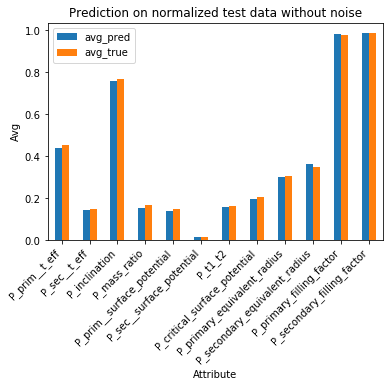

In [39]:
x = np.arange(len(eval_pred))
eval_pred[["avg_pred", "avg_true"]].plot(kind="bar")
plt.title("Prediction on normalized test data without noise")
plt.xlabel("Attribute")
plt.xticks(x, eval_pred.attribute, rotation=45, ha='right')
plt.ylabel("Avg")